In [1]:
from keras.src.utils.module_utils import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from VGG16 import VGG16  # senin yukarıdaki model dosyan


In [2]:
# File Directory for both the train and test
train_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\train"
val_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\valid"
test_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\test"

In [3]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")




In [4]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical")
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode="categorical")

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from VGG16 import VGG16  # kendi özel model dosyan

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Katmanları dondur
# Sadece son 2 blok açalım
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True


# Yeni katmanlar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4, activation='softmax')(x)

# Yeni modeli oluştur
model = Model(inputs=base_model.input, outputs=x)

# Derleme
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
checkpoint = ModelCheckpoint("best_VGG16_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=2
)


Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.51389, saving model to best_VGG16_model.keras
20/20 - 151s - 8s/step - accuracy: 0.4992 - loss: 1.0284 - val_accuracy: 0.5139 - val_loss: 0.9706 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.51389
20/20 - 152s - 8s/step - accuracy: 0.5400 - loss: 0.9760 - val_accuracy: 0.4028 - val_loss: 1.3467 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.51389
20/20 - 148s - 7s/step - accuracy: 0.5775 - loss: 0.9336 - val_accuracy: 0.4722 - val_loss: 0.9745 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy improved from 0.51389 to 0.54167, saving model to best_VGG16_model.keras
20/20 - 147s - 7s/step - accuracy: 0.5595 - loss: 0.8517 - val_accuracy: 0.5417 - val_loss: 0.9652 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_accuracy improved from 0.54167 to 0.58333, saving model to best_VGG16_model.keras
20/20 - 146s - 7s/step - accuracy: 0.6574 - loss

In [5]:
from tensorflow.keras.models import load_model

saved_model = load_model("best_VGG16_model.keras")
score = saved_model.evaluate(test_data, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

C:\Users\yaren\PycharmProjects\ResNet50-ChestCancer-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step - accuracy: 0.6906 - loss: 0.7881
Test loss: 0.7788917422294617
Test accuracy: 0.720634937286377


In [9]:
val_loss, val_acc = saved_model.evaluate(val_data, verbose=1)
print("\n📊 VALIDATION SET:")
print(f"✅ Accuracy: {val_acc:.4f}")
print(f"❌ Loss:     {val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.7795 - loss: 2.3120

📊 VALIDATION SET:
✅ Accuracy: 0.7778
❌ Loss:     2.0657


In [15]:
train_loss, train_acc = saved_model.evaluate(train_data, verbose=1)
print("\n📊 TRAIN SET:")
print(f"✅ Accuracy: {train_acc:.4f}")
print(f"❌ Loss :     {train_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.8894 - loss: 0.5622

📊 TRAIN SET:
✅ Accuracy: 0.9021
❌ Loss:     0.5739


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 800x600 with 0 Axes>

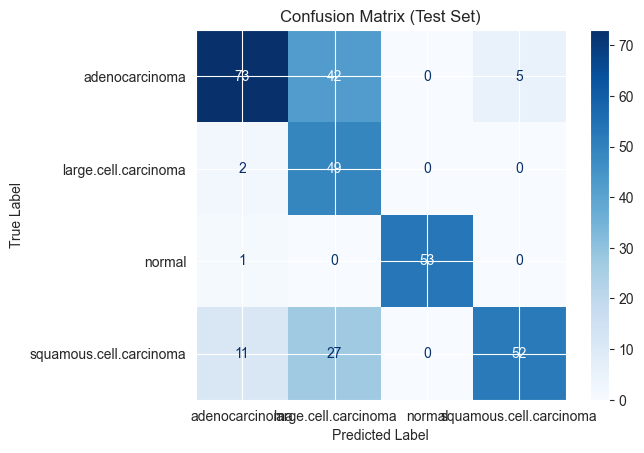


📄 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.84      0.61      0.71       120
   large.cell.carcinoma       0.42      0.96      0.58        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.91      0.58      0.71        90

               accuracy                           0.72       315
              macro avg       0.79      0.78      0.75       315
           weighted avg       0.82      0.72      0.73       315



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 🔄 Sınıf adlarını al
class_names = list(test_data.class_indices.keys())

# 🔍 Gerçek etiketleri ve tahminleri topla
y_true = []
y_pred = []

# ⚠️ test_data.shuffle = False olmalı doğru sıralama için
test_data.reset()  # Sıfırlanmazsa karışık olabilir

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = saved_model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

    # 🛑 Son batch incomplete olabilir
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 🎨 Görselleştir
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 🧾 Ekstra: classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))